# Correlation Exercises

Correlation measures the linear relationship between two continuous variables

## Telco Churn Exercise

Use the telco_churn data. 
- Does tenure correlate with monthly charges? 
- Does tenure correlated with total charges? 
- What happens if you control for phone and internet service?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pydataset import data
from scipy import stats
from env import get_url

## Plan
- Acquire the raw information from the telco_churn database
- Prepare the data for analysis. Double check for missing values and incorrect data types.
- Explore (checking for correlated and non-correlated attributes is a critical part of this step)

In [60]:
sql = """select * from customers
join internet_service_types using(internet_service_type_id)"""

In [61]:
url = get_url("telco_churn")
telco = pd.read_sql(sql, url)
telco.head()

,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,...,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,internet_service_type
0,1,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,No,...,Yes,Yes,No,2,Yes,2,65.60,593.3,No,DSL
1,1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,No,...,No,No,Yes,1,No,2,59.90,542.4,No,DSL
2,1,0013-MHZWF,Female,0,No,Yes,9,Yes,No,No,...,Yes,Yes,Yes,1,Yes,4,69.40,571.45,No,DSL
3,1,0015-UOCOJ,Female,1,No,No,7,Yes,No,Yes,...,No,No,No,1,Yes,1,48.20,340.35,No,DSL
4,1,0016-QLJIS,Female,0,Yes,Yes,65,Yes,Yes,Yes,...,Yes,Yes,Yes,3,Yes,2,90.45,5957.9,No,DSL


In [63]:
# Check for nulls in the columns of interest
assert telco.total_charges.isna().sum() == 0, "There are missing values in this column. Handle them before proceeding"
assert telco.monthly_charges.isna().sum() == 0, "There are missing values in this column. Handle them before proceeding"
assert telco.tenure.isna().sum() == 0, "There are missing values in this column. Handle them before proceeding"

In [65]:
# Check the datatypes for the columns of interest
telco[["tenure", "monthly_charges", "total_charges"]].dtypes

tenure               int64
monthly_charges    float64
total_charges       object
dtype: object

In [67]:
# Let's see what's happening with the total_charges column...
telco.total_charges.value_counts()

           11
20.2       11
19.75       9
20.05       8
19.65       8
           ..
5464.65     1
676.35      1
799.65      1
6157.6      1
870.25      1
Name: total_charges, Length: 6531, dtype: int64

In [69]:
# Make any string with multiple spaces into an empty space value
telco.total_charges = telco.total_charges.str.strip()

# Count the number of empty string entries
telco[telco.total_charges == ""]

,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,...,tech_support,streaming_tv,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,internet_service_type
318,1,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,Yes,...,Yes,Yes,No,3,No,4,56.05,,No,DSL
630,1,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,Yes,...,Yes,No,No,3,Yes,3,61.90,,No,DSL
953,1,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,No,...,Yes,Yes,No,3,No,2,73.35,,No,DSL
1052,1,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,Yes,...,Yes,Yes,No,3,Yes,3,52.55,,No,DSL
1366,1,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,Yes,...,No,Yes,Yes,3,No,2,80.85,,No,DSL
5902,3,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No internet service,...,No internet service,No internet service,No internet service,3,No,2,20.00,,No,None
5974,3,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No internet service,...,No internet service,No internet service,No internet service,2,Yes,2,19.70,,No,None
6000,3,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No internet service,...,No internet service,No internet service,No internet service,3,No,2,20.25,,No,None
6019,3,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No internet service,...,No internet service,No internet service,No internet service,3,No,2,25.35,,No,None
6188,3,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No internet service,...,No internet service,No internet service,No internet service,3,No,2,25.75,,No,None


In [72]:
# remove those 11 rows
telco = telco[telco.total_charges != ""]

# set the total_charges column to be a float
telco.total_charges = telco.total_charges.astype(float)

In [73]:
telco[["total_charges", "monthly_charges", "tenure"]].dtypes

total_charges      float64
monthly_charges    float64
tenure               int64
dtype: object

### Relationship of Tenure to Monthly Charges
$H_0$ is that there is no linear relationship between these two variables

In [74]:
alpha = .01
r, p = stats.pearsonr(telco.tenure, telco.monthly_charges)
if p < alpha:
    print("Reject our null hypothesis")
else:
    print("Fail to reject our null hypothesis")
r, p

Reject our null hypothesis


(0.2468617666408935, 3.9898213232673846e-98)

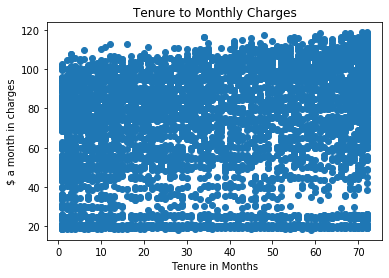

In [76]:
plt.title("Tenure to Monthly Charges")
plt.xlabel("Tenure in Months")
plt.ylabel("$ a month in charges")
plt.scatter(telco.tenure, telco.monthly_charges)
plt.show()

In [10]:
# plt.title("Distribution of tenure and monthly_charges")
# plt.hist([telco.tenure, telco.monthly_charges], label=["Tenure", "Monthly Charges"])
# plt.legend(loc="upper right")
# plt.show()

## Relationship of Tenure to Total Charges
$H_0$ is that there is no linear relationship

In [79]:
# pearson's R of tenure and total charges
alpha = .05
r, p = stats.pearsonr(telco.tenure, telco.total_charges)
if p < alpha:
    print("Reject the null")
    print("There is a linear relationship")
else: 
    print("Fail to reject the null")
r, p

Reject the null
There is a linear relationship


(0.8258804609332021, 0.0)

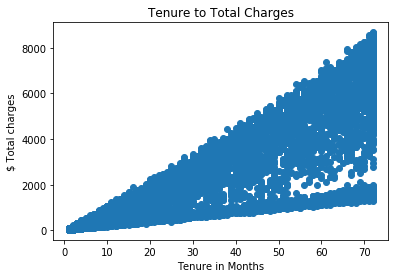

In [80]:
plt.title("Tenure to Total Charges")
plt.xlabel("Tenure in Months")
plt.ylabel("$ Total charges")
plt.scatter(telco.tenure, telco.total_charges)
plt.show()

## Relationship Between Monthly Charges and Total Charges
$H_0$: There is no linear correlation between tenure and monthly charges

In [81]:
alpha = .01 # 1 - .99 confidence level
r, p = stats.pearsonr(telco.monthly_charges, telco.total_charges)

if p < alpha:
    print("Reject our null hypothesis")

else:
    print("Fail to reject our null hypothesis")

print("R is", r)
print("p is", p)
print("alpha is", alpha)

Reject our null hypothesis
R is 0.6510648032262025
p is 0.0
alpha is 0.01


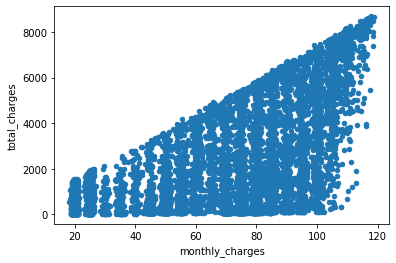

In [82]:
telco.plot.scatter("monthly_charges", "total_charges")

# Let's control for phone and internet service

In [15]:
telco.columns

Index(['payment_type_id', 'internet_service_type_id', 'contract_type_id',
       'customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'contract_type', 'internet_service_type',
       'payment_type'],
      dtype='object')

In [16]:
telco.phone_service.value_counts()

Yes    6352
No      680
Name: phone_service, dtype: int64

In [17]:
telco.internet_service_type.value_counts()

Fiber optic    3096
DSL            2416
None           1520
Name: internet_service_type, dtype: int64

### Combinations of phone and internet service
- Phone, no internet
- Phone, Fiber
- Phone, DSL
- No phone, DSL
- No phone, Fiber, (turns out that this is an empty list)
- No phone, no internet (this is an empty list)

### Let's look at phone customers with no internet service

In [83]:
phone_no_internet = telco[(telco.phone_service == "Yes") & (telco.internet_service_type == "None")]
phone_no_internet = phone_no_internet[["tenure", "monthly_charges", "total_charges"]]

In [84]:
stats.pearsonr(phone_no_internet.tenure, phone_no_internet.monthly_charges)

(0.34618773548574655, 4.896604599951957e-44)

In [85]:
stats.pearsonr(phone_no_internet.tenure, phone_no_internet.total_charges)

(0.9814648859044287, 0.0)

In [86]:
stats.pearsonr(phone_no_internet.monthly_charges, phone_no_internet.total_charges)


(0.48448535834260964, 2.767387829742139e-90)

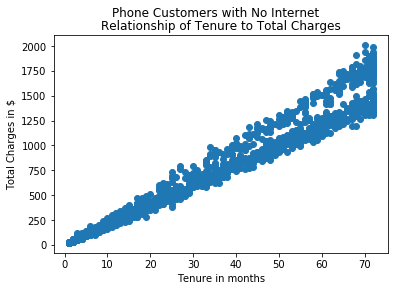

In [87]:
plt.suptitle("Phone Customers with No Internet")
plt.title("Relationship of Tenure to Total Charges")
plt.xlabel("Tenure in months")
plt.ylabel("Total Charges in $")
plt.scatter(phone_no_internet.tenure, phone_no_internet.total_charges)
plt.show()

## Customers with Phone and Fiber Internet

In [89]:
phone_fiber = telco[(telco.phone_service == "Yes") & (telco.internet_service_type == "Fiber optic")]
phone_fiber = phone_fiber[["tenure", "monthly_charges", "total_charges"]]

In [90]:
stats.pearsonr(phone_fiber.tenure, phone_fiber.total_charges)

(0.9853093528070602, 0.0)

In [91]:
stats.pearsonr(phone_fiber.tenure, phone_fiber.monthly_charges)

(0.6246206176175583, 0.0)

In [92]:
stats.pearsonr(phone_fiber.monthly_charges, phone_fiber.total_charges)

(0.7135248828873246, 0.0)

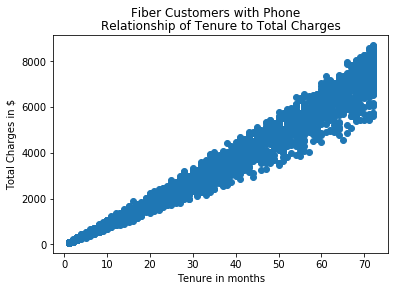

In [93]:
plt.suptitle("Fiber Customers with Phone")
plt.title("Relationship of Tenure to Total Charges")

plt.xlabel("Tenure in months")
plt.ylabel("Total Charges in $")
plt.scatter(phone_fiber.tenure, phone_fiber.total_charges)
plt.show()

## Customers with Phone and DSL

In [94]:
phone_dsl = telco[(telco.phone_service == "Yes") & (telco.internet_service_type == "DSL")]
phone_dsl = phone_fiber[["tenure", "monthly_charges", "total_charges"]]

In [95]:
stats.pearsonr(phone_dsl.tenure, phone_dsl.monthly_charges)

(0.6246206176175583, 0.0)

In [96]:
stats.pearsonr(phone_dsl.monthly_charges, phone_dsl.total_charges)

(0.7135248828873246, 0.0)

In [97]:
stats.pearsonr(phone_dsl.tenure, phone_dsl.total_charges)

(0.9853093528070602, 0.0)

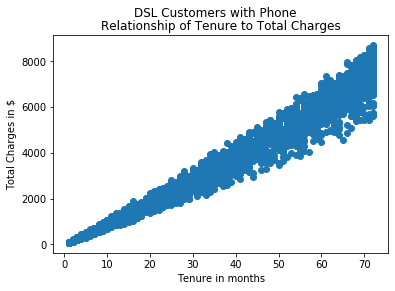

In [99]:
plt.suptitle("DSL Customers with Phone")
plt.title("Relationship of Tenure to Total Charges")

plt.xlabel("Tenure in months")
plt.ylabel("Total Charges in $")
plt.scatter(phone_dsl.tenure, phone_dsl.total_charges)
plt.show()

In [100]:
fiber_only = telco[(telco.phone_service == "No") & (telco.internet_service_type == "Fiber optic")]
fiber_only.shape # empty so we'll skip this

(0, 22)

In [101]:
dsl_only = telco[(telco.phone_service == "No") & (telco.internet_service_type == "DSL")]
dsl_only = dsl_only[["tenure", "monthly_charges", "total_charges"]]

In [102]:
stats.pearsonr(dsl_only.tenure, dsl_only.monthly_charges)

(0.5924298640568983, 1.1732739032891168e-65)

In [103]:
stats.pearsonr(dsl_only.monthly_charges, dsl_only.total_charges)

(0.7468523514575717, 3.0271096522806475e-122)

In [104]:
stats.pearsonr(dsl_only.tenure, dsl_only.total_charges)

(0.9534228506954516, 0.0)

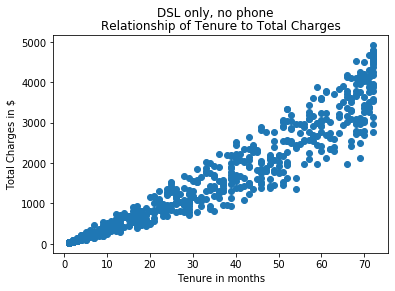

In [105]:
plt.suptitle("DSL only, no phone")
plt.title("Relationship of Tenure to Total Charges")

plt.xlabel("Tenure in months")
plt.ylabel("Total Charges in $")
plt.scatter(dsl_only.tenure, dsl_only.total_charges)
plt.show()

# Correlations in the employees database.
- Is there a relationship between how long an employee has been with the company and their salary?
- Is there a relationship between how long an employee has been with the company and the number of titles they have had?

In [118]:
sql = """
select emp_no, salary, datediff(curdate(), hire_date) as "days"
from salaries
join employees using(emp_no)
where to_date > curdate()
"""

url = get_url("employees")

In [119]:
df = pd.read_sql(sql, url)
df = df.set_index("emp_no")

In [120]:
df.head()

,salary,days
emp_no,,
10001,88958,12327
10002,72527,12544
10003,43311,12264
10004,74057,12169
10005,94692,11153


## $H_0$: There is no linear relationship between salary and employee tenure
$H_a$: there is a linear relationship

In [123]:
alpha = .01 # is 1 - a 99% confidence level

In [124]:
r, p = stats.pearsonr(df.salary, df.days)
print("R correlation coefficient", r)
print("P value, which is probability of seeing the data given the null hypothes is true", p)

R correlation coefficient 0.3064625613186078
P value, which is probability of seeing the data given the null hypothes is true 0.0


In [125]:
if p < alpha:
    print("Reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

Reject the null hypothesis.


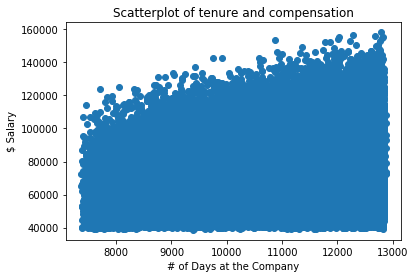

In [126]:
plt.title("Scatterplot of tenure and compensation")
plt.xlabel("# of Days at the Company")
plt.ylabel("$ Salary")
plt.scatter(df.days, df.salary)
plt.show()

In [127]:
# How can this be?
df.shape

(240124, 2)

## Is there a relationship between how long an employee has been with the company and the number of titles they have had?

#### $H_0$ There is no linear relationship between # of titles and employee tenure
#### $H_a$ There is, in fact, a linear relationship between # of titles and tenure

In [128]:
sql = """
select emp_no, 
    datediff(curdate(), hire_date) as tenure, 
    count(*) as n_titles
from employees
join titles using(emp_no)
group by emp_no
"""

In [129]:
df = pd.read_sql(sql, url)
df = df.set_index("emp_no")
df.head()

,tenure,n_titles
emp_no,,
10001,12327,1
10002,12544,1
10003,12264,1
10004,12169,2
10005,11153,2


In [130]:
# Quick and easy way to get the correlation coefficient
# Notice that this doesn't give us a p value, but it does give us the R from Pearson's R
df.corr()

,tenure,n_titles
tenure,1.000000,0.266599
n_titles,0.266599,1.000000


In [131]:
alpha = 0.01
r, p = stats.pearsonr(df.tenure, df.n_titles)
if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis.")

print("R is", r)
print("p-value is", p)
print("alpha is", alpha)

We reject the null hypothesis
R is 0.2665989299136619
p-value is 0.0
alpha is 0.01


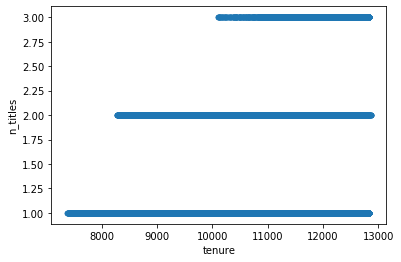

In [132]:
df.plot.scatter("tenure", "n_titles")

# Sleep Study Analysis!

### Is there a relationship between days and reaction time?
#### $H_0$ is that there is no linear relationship between days and reaction time
#### $H_a$ is that there is a (linear) relationship

In [133]:
# Let's see which of the datasets contains 'sleep' in the title.
from pydataset import data
df = data()
df[df.title.str.contains("sleep")]

,dataset_id,title
383,msleep,An updated and expanded version of the mammals sleep dataset.
705,cushny,A data set from Cushny and Peebles (1905) on the effect of three drugs on hours of sle...
756,sleepstudy,Reaction times in a sleep deprivation study


In [134]:
df = data("sleepstudy")
df.head()

,Reaction,Days,Subject
1,249.5600,0,308
2,258.7047,1,308
3,250.8006,2,308
4,321.4398,3,308
5,356.8519,4,308


In [135]:
# double check the data types
df.dtypes

Reaction    float64
Days          int64
Subject       int64
dtype: object

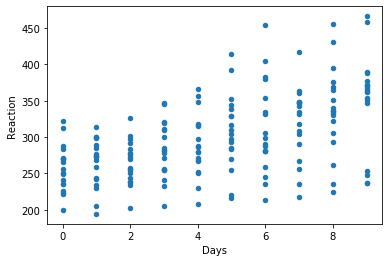

In [136]:
# Let's peek at the data first... 
df.plot.scatter("Days", "Reaction")

In [137]:
# Check for nulls
assert df.Days.isna().sum() == 0
assert df.Reaction.isna().sum() == 0

In [139]:
alpha = 0.01
r, p = stats.pearsonr(df.Days, df.Reaction)
r, p

(0.5352302262650253, 9.894096322214812e-15)

In [140]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

Reject the null hypothesis
